Suported Vector Machine (SVM)
=============================

O objetivo, nesse notebook, é `treinar` um modelo do tipo `SVM` com a biblioteca `sklearn` com bons `hiperparâmetros` e avaliar seus _resultados_. De forma mais expecífica, busca-se obter um modelo com os `hiperparâmetros` _otimizados_, assim como realizar a estratégia de _validação cruzada_ e, ao final, oubter uma `métrica` de desempenho do modelo. Nesse sentido, os passos serão os seguintes:

1. Utilizar o módulo Optuna para realizar, por meio de validaçõa cruzada, a otimizaçõa de hiperparâmetros; com base no conjunot de treino.

2. Treina rum modelo, dito oficial, com os hiperparâmetros otimizados.

3. Obter a medida de desempenho do modelo realizando o teste com o conjunto de teste, previamente separado.

OBS: Para o sklearn o SVM que se enquadra no problema de classificação é o Supported Vector Classification (SVC)

In [1]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.base import clone
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import StratifiedKFold

## Importando os dados de treino

Como discutido no notebook que realizou o tratamento geral dos dados, seu retorno seriam 4 arquivos .csv que poderiam ser importados em outros notebooks. Aqui, importo, por hora, apenas os dados que serão utilizados para treino.

X é o conjunto de features. Uma lista de listas (arrey numpy).

y é o conjunto de dados dos targets. Uma lista (arrey numpy).

In [22]:
X = pd.read_csv('Features para treino.csv', index_col='Unnamed: 0', sep=',').to_numpy()
y = pd.read_csv('Target para treino.csv', index_col='Unnamed: 0', sep=',' ).to_numpy().reshape(-1)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)  # 'Control'->0, 'Impaired'->1

## Otimização de hiperparâmetros

Cada `algoritmo` de aprendizado de máquina possue o que é chamado `hiperparâmetro`. Estes são definidos pelo _operador_ antes de o modelo ser _induzido_. Controlam características importantes do treinamento do modelo. É necessário diferenciar `hiperparâmetro` de `parâmetro`, que é o que o modelo aprenderá com os dados de `treino`. [1]

Para realizar a `otimização` será utilizado o módulo `optuna`, uma biblioteca com foco em encontrar, dado um espaço de busca, um bom conjunto de `hiperparâmetros`. O primeiro passo, então, é definir o espaço de busca. Para cada `hiperparâmetro` do modelo é possível pedir ao `optuna` que selecione, dado um _range_ de possibilidades, um valor para aplicar no trinamento.

In [3]:
# Usando o padrão da biblioteca
# modelo = SVC()
modelo = SVC(C=0.012698350955897497, kernel='linear', gamma='scale')
estratificado = StratifiedKFold(n_splits=5, shuffle=True, random_state=1141)


seletor = SequentialFeatureSelector(
    modelo,
    n_features_to_select='auto',
    direction='forward',
    scoring='f1_macro',
    cv=estratificado,
    n_jobs=-1
)

seletor.fit(X, y)

,estimator,SVC(C=0.01269...rnel='linear')
,n_features_to_select,'auto'
,tol,None
,direction,'forward'
,scoring,'f1_macro'
,cv,StratifiedKFo... shuffle=True)
,n_jobs,-1
,C,0.012698350955897497
,kernel,'linear'
,degree,3
,gamma,'scale'


In [23]:
X = seletor.transform(X)

### `Instanciando` o modelo

A função abaixo cria o que é chamado `instância` do `modelo`, no casso desse `notebook` um SVC. Ela tem como `parâmetro` um objeto do optuna "`trial`", responsável por realizar as escolhas de `hiperparâmetros`. Na função, cada `hiperparâmetro` do `modelo`, que julgou-se interessante _otimizar_, rescebe o objeto "`trial`" com a função de sortear uma `categoria`, um objeto de `ponto` `flutuante`, ou um `inteiro`.

Ponto importante é que, no caso expecífico do SVC, o hiperparâmetro "`gamma`" pode resceber tanto `strings`: "`scale`" e "`auto`" como pode resceber um `float`. Além disso, `hiperparâmetros` como "`degree` e "`coef0`" são ignorados para algumas configurações de "`kernel`". Para esses casos há os _blocos condicionais_.

Ao final, o modelo é `instanciado` com os `hiperparâmetros` definidos anteriormente.

Vale ressaltar que uma importante estratégia ao trinar modelos é `normalizar` os dados. Isso pode ser bom o ruim. Para descobrir se é `necessário`, pode-se criar um _bloco condicional_ e testar o modelo com dados normalizados e não normalizados. A normalização é, por facilidade, realizada em uma `pipeline`, que permite condensar organizar as linhsa de código.

In [5]:
def parametros_SVC(trial):
    
    parametros = {}

        # C
    parametros['C'] = trial.suggest_float('Par. regular', 1e-2, 1, log=True)

        # kernel
    parametros['kernel'] = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])

        # gamma
    tipo_gamma = trial.suggest_categorical('Tipo de gamma', ['Categórico', 'Numérico'])
    # Decide qual usar
    if tipo_gamma == 'Categórico':
        parametros['gamma'] = trial.suggest_categorical('gamma_categ', ['scale', 'auto'])
    else:
        parametros['gamma'] = trial.suggest_float('gamma_num', 1e-3, 5, log=True)
    
    # Define os parâmetros 'degree' e 'coef0'. Estes são ignorados em alguns modos de kernel, não sendo necessário testá-los (basta usar o padrão)
    if parametros['kernel'] == 'poly':
        parametros['degree'] = trial.suggest_int('degree', 2, 7)
        parametros['coef0'] = trial.suggest_float('coef0', -4.0, 2.0)
    elif parametros['kernel'] == 'sigmoid':
        parametros['degree'] = 3  # Padrão
        parametros['coef0'] = trial.suggest_float('coef0', -4.0, 2.0)
    else:
        parametros['degree'] = 3 # Padrão
        parametros['coef0'] = 0 # Padrão

    return parametros

In [6]:
def instancia_modelo(trial, X):


    parametros = parametros_SVC(trial)
    modelo = SVC(
        C=parametros['C'],
        kernel=parametros['kernel'],
        gamma=parametros['gamma'],
        degree=parametros['degree'],
        coef0=parametros['coef0']
    )

    normalizar = trial.suggest_categorical('Normalizar', [True, False])


    passo_de_normalizacao = ('normalizador', StandardScaler()) if normalizar else ('normalizador', 'passthrough')
    passo_do_SVC= ('SVC', modelo)

    passos = [
        passo_de_normalizacao,
        passo_do_SVC
    ]

    pipeline = Pipeline(passos)
    
    return pipeline

### A função objetivo

Essa função é a que agrupa o modelo, os dados e qual será a `métrico utilizada para estimar o `desempenho do modelo. Tem esse nome pois represente o objetivo de, no caso desse notebook, `maximização` da acurácio. Seu retorno é a `média` das métricas obtidas ao realizar a `validação cruzada`, sendo esta uma _estimativa do desempenho_ do modelo, e _não_ seu _desmepenho real_.

In [7]:
def objetivo(trial, X, y, folds):
    
    modelo = instancia_modelo(trial, X)

    lista_metricas = cross_val_score(
        modelo,
        X,
        y,
        scoring='f1_macro',
        cv=folds,
    )

    return lista_metricas.mean()

### O estudo do `optuna`

Antes de otimizar os `hiperparâmetros`, cria-se um estudo. Este tem a função de `armazenar` os dados que já foram testados e as métricas obtidas em cada teste. Além disso, é possível criar um arquivo de _banco de dados_ que guarda as informações sobre o teste. Assim, será criado um arquivo com nome: "`estudo_SVM_SVC`". Esse arquivo pode ser útil, também para recuperar o que já foi realizado em caso de o computador desligar, por exemplo.

In [8]:
from optuna import create_study

nome_estudo = 'SVM_teste_f1_macro'

estudo = create_study(
    direction='maximize',
    study_name=nome_estudo,
    storage=f"sqlite:///{nome_estudo}.db",
    load_if_exists=True,
)

c:\venvs\quest4_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-11-02 16:35:48,776] Using an existing study with name 'SVM_teste_f1_macro' instead of creating a new one.


### Um teste escolhido a dedo

Pode-se, por ocasião, suspeitar que um certo conjunto de `hiperparâmetros` venha a conceber o _melhor desempenho_. Para não depender da sorte de o `optuna` testar o conjunto em questão, é possível `solicitar` que o conjunto seja testado. Nessa situação, a célula abaixo solicita que seja feito o teste com os `hiperparâmetros` padrão definidos pelo `sklearn`, tanto com os dados normalizados, quanto com os dados "crus".

O otimizador já foi rodado várias vezes durante a concepção do código. Esse fato leva a um melhor ajuste do espaço de busca e ao acúmulo de chutes mais precisos. Ou seja, durante a operação do otimizador, algumas combinações de hiperparâmetros foram salvas em forma de dicionário para que, ao rodar uma última vez, essas configurações fossem repetidas. Além disso, para esse modelo a otimização com 500 tentativas durou cerca de 4 minutos, o que não é um complicaçõa. Isso leva a crer que não será necessário realizar a seleção de parâmetros.

In [9]:
# lista_dicionarios = [
#     {'normalizar': False, 'Parâmetro de regularização': 1.0, 'kernel': 'rbf', 'Tipo de gamma': 'Categórico', 'gamma_categ': 'scale', 'degree': 3, 'coef0': 0.0},
#     {'normalizar': True, 'Parâmetro de regularização': 1.0, 'kernel': 'rbf', 'Tipo de gamma': 'Categórico', 'gamma_categ': 'scale', 'degree': 3, 'coef0': 0.0},
#     {'Parâmetro de regularização': 0.2808003888968255, 'kernel': 'linear', 'Tipo de gamma': 'Categórico', 'gamma_categ': 'auto', 'degree': 3, 'coef0': 0.0, 'normalizar': False},
#     {'Parâmetro de regularização': 0.01704103541424163, 'kernel': 'linear', 'Tipo de gamma': 'Categórico', 'gamma_categ': 'scale', 'degree': 3, 'coef0': 0.0, 'normalizar': False} # 10 folds
# ]

# for i in lista_dicionarios:
#     estudo.enqueue_trial(i)

### Otimizar

Com as funções definidas basta iniciar a `otimizção`. O único detalhe é que o `optuna` aceita em sua função `optimize` apenas uma função de um `argumento`, o argumento `trial`. Para contornar essa situação, cria-se a função nomeada de "`objetivo_parcial`". Ela rescebe apenas o `argumento` `trial` e _retorna a função objetivo_.

Feita essa função, basta otimizar. Defini-se o número de folds que serão utilizados na validação cruzada, (escolhida para gerar a estimativa da métirca) definida como 10. E o número de tentativas que serão realizadas, neste caso, 200. 

In [10]:
folds = 5

def objetivo_parcial(trial):
    return objetivo(trial, X, y, folds)

In [11]:
tentativas = 5

estudo.optimize(objetivo_parcial, n_trials=tentativas, n_jobs=7)

[I 2025-11-02 16:35:57,839] Trial 1239 finished with value: 0.7059963656760011 and parameters: {'Par. regular': 0.03470041097072725, 'kernel': 'poly', 'Tipo de gamma': 'Categórico', 'gamma_categ': 'auto', 'degree': 7, 'coef0': 0.4876858034465177, 'Normalizar': False}. Best is trial 145 with value: 0.7974767712136133.
[I 2025-11-02 16:35:57,977] Trial 1237 finished with value: 0.7059963656760011 and parameters: {'Par. regular': 0.03830968281583951, 'kernel': 'poly', 'Tipo de gamma': 'Categórico', 'gamma_categ': 'auto', 'degree': 7, 'coef0': 0.5067298304689403, 'Normalizar': False}. Best is trial 145 with value: 0.7974767712136133.
[I 2025-11-02 16:35:58,243] Trial 1238 finished with value: 0.7059963656760011 and parameters: {'Par. regular': 0.03785090807310458, 'kernel': 'poly', 'Tipo de gamma': 'Categórico', 'gamma_categ': 'auto', 'degree': 7, 'coef0': 0.565400882349921, 'Normalizar': False}. Best is trial 145 with value: 0.7974767712136133.
[I 2025-11-02 16:36:05,927] Trial 1235 finis

### Resultado

Após a finalizaçõa da otimizaçõa, é possíve vizualizar os dados em forma de `Dataframe`.

In [12]:
resultado = estudo.trials_dataframe()
resultado

,number,value,datetime_start,datetime_complete,duration,params_Normalizar,params_Par. regular,params_Tipo de gamma,params_coef0,params_degree,params_gamma_categ,params_gamma_num,params_kernel,state
0,0,0.420926,2025-11-02 01:51:20.134726,2025-11-02 01:51:22.017283,0 days 00:00:01.882557,True,0.045878,Categórico,NaN,NaN,auto,NaN,rbf,COMPLETE
1,1,0.716169,2025-11-02 01:51:20.166806,2025-11-02 01:51:23.341844,0 days 00:00:03.175038,False,0.876838,Numérico,-0.538726,5.0,NaN,0.001132,poly,COMPLETE
2,2,0.420926,2025-11-02 01:51:20.146866,2025-11-02 01:51:22.193366,0 days 00:00:02.046500,False,0.556460,Categórico,-0.677121,NaN,auto,NaN,sigmoid,COMPLETE
3,3,0.639887,2025-11-02 01:51:20.282461,2025-11-02 01:51:22.023573,0 days 00:00:01.741112,True,0.191360,Categórico,-1.853636,7.0,scale,NaN,poly,COMPLETE
4,4,0.420926,2025-11-02 01:51:20.319430,2025-11-02 01:51:21.280883,0 days 00:00:00.961453,True,0.127304,Categórico,0.315821,NaN,scale,NaN,sigmoid,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,1235,0.705788,2025-11-02 16:35:49.682452,2025-11-02 16:36:05.879694,0 days 00:00:16.197242,False,0.037904,Categórico,-1.789400,7.0,auto,NaN,poly,COMPLETE
1236,1236,0.712220,2025-11-02 16:35:49.753727,2025-11-02 16:36:14.778401,0 days 00:00:25.024674,False,0.038387,Categórico,-1.960029,7.0,auto,NaN,poly,COMPLETE
1237,1237,0.705996,2025-11-02 16:35:49.798242,2025-11-02 16:35:57.924915,0 days 00:00:08.126673,False,0.038310,Categórico,0.506730,7.0,auto,NaN,poly,COMPLETE
1238,1238,0.705996,2025-11-02 16:35:49.849243,2025-11-02 16:35:58.203905,0 days 00:00:08.354662,False,0.037851,Categórico,0.565401,7.0,auto,NaN,poly,COMPLETE


Mais interessante é encontrar a _melhor tentativa_ com o código da célula abaixo. Elá exibe o `índice` da melhor tentativa, a `estimativa` da métrica e o conjunto de `hiperparâmetros` utilizados.

In [13]:
melhor_trial = estudo.best_trial

print(f'Número do melhor trial: {melhor_trial.number}, com métrica de {melhor_trial.value}')
print(f'Parâmetros do melhor trial: {melhor_trial.params}')

Número do melhor trial: 145, com métrica de 0.7974767712136133
Parâmetros do melhor trial: {'Par. regular': 0.04660348660145515, 'kernel': 'linear', 'Tipo de gamma': 'Categórico', 'gamma_categ': 'auto', 'Normalizar': False}


## Treino do modelo oficial

Pela última `célula` da seção anterior, o melhor conjunto de `hiperparâmetros` é o representado no `dicionário` abaixo:

In [14]:
{'Par. regular': 0.04660348660145515, 'kernel': 'linear', 'Tipo de gamma': 'Categórico', 'gamma_categ': 'auto', 'Normalizar': False}

{'Par. regular': 0.012698350955897497, 'kernel': 'linear', 'Tipo de gamma': 'Categórico', 'gamma_categ': 'scale', 'Selecionar': True, 'Normalizar': True}

{'Par. regular': 0.012698350955897497,
 'kernel': 'linear',
 'Tipo de gamma': 'Categórico',
 'gamma_categ': 'scale',
 'Selecionar': True,
 'Normalizar': True}

Com esse conjunto em mãos, podemos finalmente induzir o modelo oficial. Ele será trinado com _todos_ os dados de treino. Como alguns dos valores acima são resultados dos blocos condicionais, a digitação terá de ser realizada manualmente. Por ocasião, a normalização não foi necessária.

In [24]:
modelo_oficial = SVC(C=0.012698350955897497, kernel='linear', gamma='scale')

passo_de_normalizacao = ('normalizador', StandardScaler())
passo_do_SVC= ('SVC', modelo_oficial)

passos = [
    passo_de_normalizacao,
    passo_do_SVC
]

pipeline = Pipeline(passos)


# modelo_oficial.fit(X, y)
pipeline.fit(X, y)

,steps,"[('normalizador', ...), ('SVC', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,0.012698350955897497
,kernel,'linear'
,degree,3
,gamma,'scale'


## Medida de desempenho

O que fizemos durante a `otimização` foi a validação cruada do desempenho do modelo. Pegávamos uma partição do conjunto de treino e utilizávamos como teste. Em uma próxima iteração, esse conjunto era alterado e assim por diante, até completar os k folds. Ao final, retornava-se a média, uam `estimativa` do desempenho. Agora, o objetivo é obter a `medida` do desempenho. Para isso, vamos utilizar os `dados` de `teste` que, até agora, _permaneceram guardados_. A célula abaixo _importa_ os dados de teste.

In [26]:
X_teste = pd.read_csv('Features para teste.csv', index_col='Unnamed: 0', sep=',').to_numpy()
y_teste = pd.read_csv('Target para teste.csv', index_col='Unnamed: 0', sep=',' ).to_numpy().reshape(-1)

y_teste = le.fit_transform(y_teste)
X_teste = seletor.transform(X_teste)

A métrica utilizada para avaliar o desempenho será, primariamente, a acurácia do modelo. A célual abaixo calcula justamente a acurácia do modelo.

In [27]:
y_verdadeiro = y_teste
y_previsto = modelo_oficial.predict(X_teste)

acuracia = accuracy_score(y_verdadeiro, y_previsto)

print(f'A acurácia do modelo é de {100 * acuracia:.2f}%')

A acurácia do modelo é de 72.62%


## Visualização gráfica

[0 1]


<Axes: >

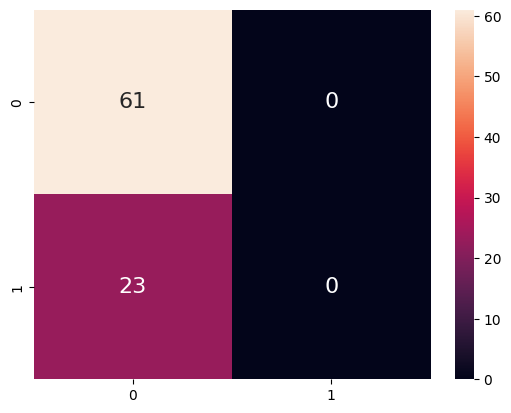

In [29]:
#Montando a matriz de confusão 
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

classes = np.unique(y_verdadeiro)
print(classes)
cm = confusion_matrix(y_verdadeiro, y_previsto, labels=classes)
df_conf = pd.DataFrame(cm, classes, classes)
sns.heatmap(df_conf, annot=True, annot_kws={"size": 16})

## Referências

1. Conceito de hiperparâmetro e otimizaçõa de hiperparâmetros: https://www.ibm.com/br-pt/think/topics/hyperparameter-tuning